## Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

from xgboost import XGBClassifier

## Lectura del dataset

Cargamos los datos de entrenamiento que vamos a utilizar para generar nuestro modelo y los de test para la competencia de Kaggle. 

In [3]:
df_train = pd.read_csv('diabetes_prediction_dataset_train-labeled.csv')
df_test = pd.read_csv('diabetes_prediction_dataset_test.csv')

In [4]:
X = df_train.drop(columns=['patient', 'diabetes'])
y = df_train['diabetes']
x_train, x_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state = 8)

In [5]:
x_test = df_test.drop(columns=['patient', 'diabetes'])
y_test = df_test['diabetes']
PatientId_test = df_test['patient']

## Preprocesamiento

In [6]:
pipeline = joblib.load('../preproc_pipeline.pkl')

In [7]:
x_train_transformed = pipeline.transform(x_train)
x_val_transformed = pipeline.transform(x_val)
x_test_transformed = pipeline.transform(x_test)

## Entrenamiento del modelo sin ajuste de hiperparámetros

In [10]:
name = 'XGBClassifier'
xgb = XGBClassifier()
xgb.fit(x_train_transformed, y_train)
train_predictions = xgb.predict(x_train_transformed)
accuracy = accuracy_score(y_train, train_predictions)
print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

val_predictions = xgb.predict(x_val_transformed)
accuracy = accuracy_score(y_val, val_predictions)
print(f"Accuracy validation {name}: %.2f%%" % (accuracy * 100.0))

Accuracy train XGBClassifier: 97.60%
Accuracy validation XGBClassifier: 97.30%


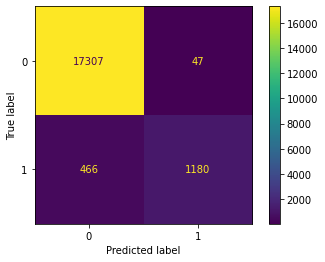

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17354
           1       0.96      0.72      0.82      1646

    accuracy                           0.97     19000
   macro avg       0.97      0.86      0.90     19000
weighted avg       0.97      0.97      0.97     19000



In [12]:
ConfusionMatrixDisplay.from_predictions(y_val,val_predictions)
plt.show()
print(classification_report(y_val,val_predictions))

## Ajuste de hiperparámetros 1

Se realiza un GridSearchCV sobre algunos de los hiperparámetros de xgboost

In [14]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

grid = GridSearchCV(XGBClassifier(), params)
grid.fit(x_train_transformed,y_train)
grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 6,
 'n_estimators': 1000}

Accuracy train XGBoost: 97.22%
Accuracy test XGBoost: 97.35%


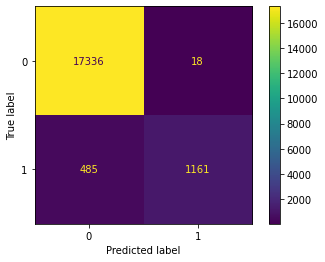

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17354
           1       0.98      0.71      0.82      1646

    accuracy                           0.97     19000
   macro avg       0.98      0.85      0.90     19000
weighted avg       0.97      0.97      0.97     19000



In [ ]:
xgb = XGBClassifier(**grid.best_params_).fit(x_train_transformed, y_train)

train_predictions = xgb.predict(x_train_transformed)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train XGBoost: %.2f%%" % (accuracy * 100.0))

val_predictions = xgb.predict(x_val_transformed)
accuracy = accuracy_score(y_val, val_predictions)
print("Accuracy validation XGBoost: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_val, val_predictions)
plt.show()

print(classification_report(y_val,val_predictions))

In [ ]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train_transformed)
y_train2 = np.array(y_train)


xgb = XGBClassifier(**grid.best_params_)
name = 'XGBClassifier'
print(xgb)
avg_accuracy = 0
for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
    xi, yi = x_train2[train_idx], y_train2[train_idx]
    x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
    xgb = xgb.fit(xi, yi)

    val_predictions = xgb.predict(x_valid)
    accuracy = accuracy_score(y_valid, val_predictions)
    avg_accuracy +=accuracy
    print(f"Precisión validation fold {fold}: {accuracy * 100.0 :.2f}" % ())

avg_accuracy /= FOLDS
print(f'Avg. accuracy = {avg_accuracy * 100}')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Precisión test fold 0: 97.21
Precisión test fold 1: 97.15
Precisión test fold 2: 97.22
Precisión test fold 3: 97.01
Precisión test fold 4: 97.15
Avg. accuracy = 97.15


In [46]:
val_predictions = xgb.predict(x_val_transformed)
accuracy = accuracy_score(y_val, val_predictions)
print("Accuracy validation XGBoost: %.2f%%" % (accuracy * 100.0))

Accuracy test XGBoost: 97.36%


## Ajuste de hiperparámetros 2

Se realiza un ajuste de hiperparámetros más extenso que en el punto anterior usando un RandomizedSearchCV

In [32]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 1.0],
    'scale_pos_weight': [1, 2, 5],
}
xgb2 = XGBClassifier(random_state=42)
grid2 = RandomizedSearchCV(
    estimator=xgb2,
    param_distributions=param_grid,
    n_iter=1000,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    random_state=42,
    verbose=3
)
grid2.fit(x_train_transformed,y_train)
grid2.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV 2/5] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=0.9;, score=0.972 total time=   5.0s
[CV 3/5] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=0.9;, score=0.973 total time=   5.0s
[CV 4/5] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=0.9;, score=0.970 total time=   5.0s
[CV 1/5] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=0.9;, score=0.971 total time=   5.0s
[CV 5/5] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, min_

{'subsample': 1.0,
 'scale_pos_weight': 1,
 'reg_lambda': 1.0,
 'reg_alpha': 0.5,
 'n_estimators': 200,
 'min_child_weight': 1,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 1.0}

Accuracy train XGBoost: 97.23%
Accuracy test XGBoost: 97.37%


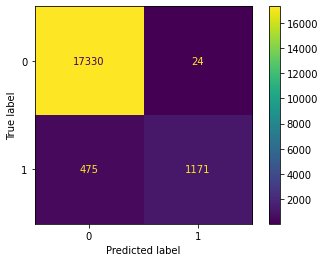

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17354
           1       0.98      0.71      0.82      1646

    accuracy                           0.97     19000
   macro avg       0.98      0.86      0.91     19000
weighted avg       0.97      0.97      0.97     19000



In [43]:
xgb2 = XGBClassifier(**grid2.best_params_).fit(x_train_transformed, y_train)

train_predictions = xgb2.predict(x_train_transformed)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train XGBoost: %.2f%%" % (accuracy * 100.0))

test_predictions = xgb2.predict(x_test_transformed)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test XGBoost: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,xgb2.predict(x_test_transformed)))

In [47]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train_transformed)
y_train2 = np.array(y_train)


xgb2 = XGBClassifier(**grid2.best_params_)
name = 'XGBClassifier'
print(xgb2)
avg_accuracy = 0
for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
    xi, yi = x_train2[train_idx], y_train2[train_idx]
    x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
    xgb2 = xgb2.fit(xi, yi)

    test_predictions = xgb2.predict(x_valid)
    accuracy = accuracy_score(y_valid, test_predictions)
    avg_accuracy +=accuracy
    print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

avg_accuracy /= FOLDS
print(f'Avg. accuracy = {avg_accuracy * 100}')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Precisión test fold 0: 97.19
Precisión test fold 1: 97.12
Precisión test fold 2: 97.23
Precisión test fold 3: 97.01
Precisión test fold 4: 97.19
Avg. accuracy = 97.14736842105263


In [48]:
test_predictions = xgb2.predict(x_test_transformed)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test XGBoost: %.2f%%" % (accuracy * 100.0))

Accuracy test XGBoost: 97.34%


## Generar la salida para entregar

In [39]:
x_test_transformed = pipeline.transform(x_test)

In [41]:
# Con el método get_features_names_out se puede obtener el nombre de las columnas creadas
pipeline.transformers_[0][1].get_feature_names_out()

array(['gender_Male', 'gender_Other', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current'],
      dtype=object)

In [51]:
test_id = PatientId_test
test_pred = np.int64(xgb2.predict(x_test_transformed))

Con el resultado predicho generamos el archivo `.csv` para subir a la competencia de kaggle:

In [52]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("submission_xgboost_02.csv", header=True, index=False)